<a id='top'></a>
# How to Leverage *Client Insights for Wealth Management*

This notebook uses sample data to illustrate the types of results and information available in Client Insights for Wealth Management to assist advisors in preparing for an upcoming meeting with an existing client.  We'll look at various common advisor activities such as:
* preparing to defend the relationship from a potential request to leave for another advisor
* preparing products and recommendations ahead of a meeting by gaining insights into the client's recent or impending life changes 
* identifying cross-sell and up-sell opportunities by reviewing existing product ownership and service provision / subscription augmented by leads from the analytics
* benchmarking the client, enabling the provision of typical actions, events and holdings of "similar" clients by identifying the customer's segment 

This information can also assist an advisor in preparing for the meeting by identifying potential new requirements or changes to existing requirements, and by providing a more personal touch through more detailed knowledge of recent events in the client's life or financial status.

### Contents
* <a href="#env">Set-up the environment</a>
* <a href="#profile">Retrieve the complete client profile</a>
* <a href="#basic">Understand basic client information</a>
* <a href="#leave">Retain clients - propensity for attrition</a>
* <a href="#product">Assess needs by product</a>
* <a href="#life">Identify upcoming life events</a>
* <a href="#segment">Segment clients</a>
* <a href="#why">Determine underlying reasons</a>
* <a href="#trend">Gain perspective</a>

<a id='env'></a>
### Set-up the environment

Load key modules that we'll use to keep track of time and interact with the REST API, specify the API_KEY for the service and set key parameters.

In [276]:
import requests
import time
import json
from pandas.io.json import json_normalize
import pandas as pd
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter, TerminalTrueColorFormatter
import matplotlib.pyplot as plt

api_key = "41e75df9-0d8f-4063-bf72-facad8d1fd7a"  #api_key = "b981c399-0513-4d29-a9e5-882ef07e8ba9" # alternative api key

host = "ci-api.mybluemix.net"
basePath = "/api/v2/wealth/"
base_url = "https://" + host + basePath #  the path to the Client Insights for Wealth Management service on IBM Cloud

api_context = "application/json" #  the type of information we're passing to the API
head = {"Authorization" : api_key, 
        "Content-Type" : api_context} # the headers we're using with the API to provide context and authorization

effective_date = "2017-12-31" # the date used to get records with the most recent date
page_size = 500

In [277]:
customer_id = 5964
#customer_id = 5288
#customer_id = 1975
#customer_id = 1495
#customer_id = 3652
#customer_id = 5412
#customer_id = 5717

**Note**: Please feel free to try any of the above customer_ids to see different results. We have written the commentary for customer ID 5964 only, however.

<a href="#top">Return to Top</a>

<a id='profile'></a>
## Retrieve the complete client profile

In this section, we'll build a profile for a particular customer.  For purposes of illustration, we've selected the customer ID 5964.  We'll retrieve basic information and attrition score for the client and then identify the products this customer is most likely to consider and examine relevant life events.  The final element is a description of the segment to which this client belongs.  As we go through each element of the profile, comments will discuss potential usage in preparing for our client meeting.

In [278]:
print("Retrieve the entire profile of a specific customer " + str(customer_id))

customer_url = "customers/" + str(customer_id) + "/profile"
print("GET customer from: " + base_url + customer_url, end="\r", flush=True) 
customerGet = requests.get(base_url + customer_url,headers=head)

if customerGet.status_code != 200: 
    print('\nAn error occured getting customer') 
    print('customerGet Status Code: ' + str(customerGet.status_code)) 
    print(customerGet.text)

profile = json.dumps(customerGet.json(), indent=4, sort_keys=True)
print(highlight(profile, JsonLexer(), TerminalTrueColorFormatter()))  
# remove the comment from the beginning of the line above to see the full results

Retrieve the entire profile of a specific customer 5964
[ET customer from: https://ci-api.mybluemix.net/api/v2/wealth/customers/5964/profile
    {
        "customer": {
            "address_home_city": "Pallet Town",
            "address_home_country": "USA",
            "address_home_state": "Illinois",
            "address_last_changed_date": "2011-04-29",
            "advertising_indicator": true,
            "aggregation_opt_in_indicator": true,
            "customer_behavior": "semper viverra",
            "customer_id": "5964",
            "effective_date": "2016-03-03",
            "geographic_area_home": "USA Illinois",
            "geographic_area_mailing": "USA Illinois",
            "geographic_area_work": "USA Illinois",
            "head_of_household_indicator": true,
            "household_id": "93651",
            "importance_level_code": "Normal priority",
            "influence_score": 84090,
            "market_group": "tristique",
            "preferred_communication

This is clearly too much information to process all at once.  Rather than attempting to do so, let's break it into its key components:
* basic information about the client
* scores for events - that is, the likelihood that the client will experience a particular event for each of a list of events
* scores for products - that is, the likelihood that the client will require (or buy) a particualr product (or service) for each of a list of products
* the list of products the client owns, including services to which he or she is subscribed
* scores about the client, for example, the likelihood of their departure 
* summaries of their activities and accounts over the last few months

<a href="#top">Return to Top</a>

<a id='basic'></a>
## Understand Basic Client Information

Includes general information about the client.  Note that in some fields, our sample data uses unrealistic placeholder information meant only to show the basic type of information that would be included (e.g., text or a number). 

This is a very small amount of the overall customer profile information used in the predictive models. It is meant to ensure consistency with the source system while reducing the amount of information exposed through the API. Our APIs have been designed from the ground up using “privacy by design” principles and contain no more information about individual clients than is necessary to drive analytical results. 

Note that there is no personally identifying information in Client Insights for Wealth Management - neither the API nor the core data used in predictive modeling.  All data is de-identified and managed by a "Customer ID".  You will need to link this ID back to an internal reference system to map the results from this API into the context of the advisor dashboard.  Within the solution, however, we do utilize and provide back some key demographic information such as the general location of the client, the length of their relationship with the (advisory) firm, and when the available information was last updated.  Generally, the application used by the advisor, be that some form of Advisor Desktop or CRM, would receive a more complete history and personal information, including the client’s actual name and identity from the financial institution’s own systems. 

In [279]:
jcomplete_profile = json.loads(profile)[0]
jcustomer_info = jcomplete_profile['customer']
#print(highlight(json.dumps(jcustomer_info, indent=4, sort_keys=True), JsonLexer(), TerminalTrueColorFormatter())) # remove the comment from the beginning of this line to see the full results
dfbasic = json_normalize(jcustomer_info)

### Alternative API call

The following code can be used to retrieve ONLY this portion of the client information from the API directly.  You may remove the comments and execute the code.  It will produce identical output from the subsequent print statements.

In [280]:
#print("Retrieve a specific customer " + str(customer_id))

#customer_url = "customers/" + str(customer_id)
#print("GET customer from: " + base_url + customer_url, end="\r", flush=True) 
#customerGet = requests.get(base_url + customer_url,headers=head)

#if customerGet.status_code != 200: 
#    print('\nAn error occured getting customer') 
#    print('customerGet Status Code: ' + str(customerGet.status_code)) 
#    print(customerGet.text)

#dfbasic = json_normalize(customerGet.json())

In [281]:
print("Location: ", dfbasic.geographic_area_home[0])
print("Head of Household? ", dfbasic.head_of_household_indicator[0])
print("Current Status: ", dfbasic.status[0])
print("Client Since: ", dfbasic.relationship_start_date[0])
print("Last Update: ", dfbasic.effective_date[0])
print("Marketing Opt In: ", dfbasic.advertising_indicator[0])

Location:  USA Illinois
Head of Household?  True
Current Status:  Active
Client Since:  2016-03-03
Last Update:  2016-03-03
Marketing Opt In:  True


We can also investigate some behaviour summary information over time.  In our sample data set we've replicated much of this history, so expect to see repeating values in the table.

In [282]:
jsummaries = jcomplete_profile['summaries']
#print(highlight(json.dumps(jsummaries, indent=4, sort_keys=True), JsonLexer(), TerminalTrueColorFormatter())) 
# remove the comment from the beginning of the line above to see the full results
recent = pd.DataFrame.from_dict(jsummaries)
print(recent[['start_date','type','number_of_active_accounts', 'log_ins_market_downturn']][-5:])

    start_date     type  number_of_active_accounts  log_ins_market_downturn
15  2017-06-01  Monthly                          2                       99
16  2017-07-01  Monthly                          2                       99
17  2017-08-01  Monthly                          2                       99
18  2017-09-01  Monthly                          2                       99
19  2017-10-01  Monthly                          2                       99


<a href="#top">Return to Top</a>

<a id='leave'></a>
## Retain clients - propensity for attrition

The most fundamental prediction we make concerning the client is their propensity to leave the advisor.  Client retention is a challenge in the fast-paced environment of today's wealth management firms and often a source of decreased revenues.  The goal of retaining clients - preventing attrition - if often high on an advisor's list.  

We can see predicted values for the client's propensity to attrite (i.e., leave) in the table below.  They are identified by the score_code "ATTRITION".  The table shows several values at an effective_date (the date at which the prediction was computed) and forecast_horizon (the length of time into the future that was considered in the prediction.  For example, a score_value of 0.046 on effective_date 2017-12-31 over a forecast_horizon of 1 means that there is a 4.6% chance that the client will leave between January 1, 2018 and January 31, 2018 given data up to the end of December.

In [283]:
jscores = jcomplete_profile['scores']
#print(highlight(json.dumps(jscores, indent=4, sort_keys=True), JsonLexer(), TerminalTrueColorFormatter())) 
# remove the comment from the beginning of the line above to see the full results

# Convert to a data frame and show all products owned by this client
sdf = pd.DataFrame.from_dict(jscores)
print(sdf[['score_code','forecast_horizon','effective_date', 'score_value']])

             score_code  forecast_horizon effective_date  score_value
0  DYNAMIC_SEGMENTATION                 0     2017-12-31          NaN
1             ATTRITION                 1     2017-12-31     0.046154
2             ATTRITION                 3     2017-12-31     0.024685
3             ATTRITION                 6     2017-12-31     0.245804


We will return later to look into the meaning of "dynamic segmentation."

### Alternative API call

The following code can be used to retrieve ONLY this portion of the information from the API directly.  You may remove the comments and execute the code.  It will produce identical output from the subsequent print statements.

In [284]:
#resp_json = []
#while True:
#    scores_url = "customers/" + str(customer_id) + "/scores?page_size=" + str(page_size) + "&page=" + str(page) + "&score_code=ATTRITION&effective_date="+effective_date
#    print("GET page " + str(page) + " from: " + base_url + scores_url, end="\r", flush=True)
#    scoresGet = requests.get(base_url + scores_url,headers=head)
#    if scoresGet.status_code != 200 or scoresGet.json() == []: break
#    page = page + 1
#    resp_json = resp_json + scoresGet.json()
#
#if scoresGet.status_code != 200:
#    print('\nAn error occured getting scores')
#    print('scoresGet Status Code: ' + str(scoresGet.status_code))
#    print(scoresGet.text)
#    
#dfscores = json_normalize(resp_json)
#json_str = json.dumps(resp_json, indent=4, sort_keys=True)
#print("\n")
#jdf = pd.DataFrame.from_dict(json.loads(json_str))
#print(jdf[['score_code','forecast_horizon','effective_date', 'score_value']])

<a href="#top">Return to Top</a>

<a id='product'></a>
## Assess needs by product

In [285]:
jproducts = jcomplete_profile['products']
#print(highlight(json.dumps(jproducts, indent=4, sort_keys=True), JsonLexer(), TerminalTrueColorFormatter())) 
# remove the comment from the beginning of the line above to see the full results

print("\nThe client owns the following products:\n")
# Convert to a data frame and show all products owned by this client
pdf = pd.DataFrame.from_dict(jproducts)
print(pdf[['name','status','line_of_business']])


The client owns the following products:

           name  status line_of_business
0     Brokerage  Active    Mass Affluent
1  Cash Savings  Active    Mass Affluent


In [286]:
# JSON INTERPRETATION - direct, without the use of dataframes
# Show the first product owned by this client directly from json (insert a loop to see them all easily)
#dfbasic = json_normalize(jproducts)
#print("First product name: ", dfbasic.name[0])
#print("First product status: ", dfbasic.status[0])
#print("First product line of business: ", dfbasic.line_of_business[0])
#print("\n")

In [287]:
jproduct_scores = jcomplete_profile['product_scores']
#print(highlight(json.dumps(jproduct_scores, indent=4, sort_keys=True), JsonLexer(), TerminalTrueColorFormatter())) 
# remove the comment from the beginning of the line above to see the full results
print("\nBased on the buying habits and requirements of other clients, this client may soon require some of the following products:\n")
psdf = pd.DataFrame.from_dict(jproduct_scores)
print(psdf[['product_id','effective_date', 'score_value']])


Based on the buying habits and requirements of other clients, this client may soon require some of the following products:

        product_id effective_date  score_value
0        Brokerage     2017-06-30     0.354712
1        Education     2017-12-31     0.184776
2  RetirementBasic     2017-06-30     0.530689
3          Savings     2017-12-31     0.431295


Above we can see the likelihood (score_value) of various products (product_id) appealing to the client at this point in time, as calculated on the shown effective_date.

### Alternative API call

The following code can be used to retrieve ONLY this portion of the information from the API directly.  You may remove the comments and execute the code.  It will produce identical output from the subsequent print statements.

In [288]:
#resp_json = []
#while True:
#    scores_url = "customers/" + str(customer_id) + "/product_scores?page_size=" + str(page_size) + "&page=" + str(page) + "&effective_date="+effective_date
#    print("GET page " + str(page) + " from: " + base_url + scores_url, end="\r", flush=True)
#    scoresGet = requests.get(base_url + scores_url,headers=head)
#    if scoresGet.status_code != 200 or scoresGet.json() == [] : break
#    page = page + 1
#    resp_json = resp_json + scoresGet.json()
#    
#if scoresGet.status_code != 200:
#    print('\nAn error occured getting scores')
#    print('scoresGet Status Code: ' + str(scoresGet.status_code))
#    print(scoresGet.text)
#
#dfpp = json_normalize(resp_json)
#json_str = json.dumps(resp_json, indent=4, sort_keys=True)
#print("\n")
#print(highlight(json_str, JsonLexer(), TerminalTrueColorFormatter()))

<a href="#top">Return to Top</a>

<a id='life'></a>
## Identify upcoming life events

In [289]:
jevent_scores = jcomplete_profile['event_scores']
#print(highlight(json.dumps(jevent_scores, indent=4, sort_keys=True), JsonLexer(), TerminalTrueColorFormatter())) 
# remove the comment from the beginning of the line above to see the full results

# Convert to a data frame and show all flagged life events for this client
esdf = pd.DataFrame.from_dict(jevent_scores)
print(esdf[['event_type_id','forecast_horizon','effective_date', 'score_value']])

       event_type_id  forecast_horizon effective_date  score_value
0  LFE_HOME_PURCHASE                 3     2017-12-31     0.002548
1  LFE_HOME_PURCHASE                 6     2017-12-31     0.000778
2     LFE_RELOCATION                 3     2017-12-31     0.014690
3     LFE_RELOCATION                 6     2017-12-31     0.003439


Above we see various types of life events (event_type_id) that we are predicting may occur with (forecast_horizon) months of the effective_date.  The probability of the occurence, often quite low, is shown in score_value.

### Alternative API call

The following code can be used to retrieve ONLY this portion of the information from the API directly.  You may remove the comments and execute the code.  It will produce identical output from the subsequent print statements.

In [290]:
#resp_json = []
#page = 0
#while True:
#    scores_url = "customers/" + str(customer_id) + "/event_scores?page_size=" + str(page_size) + "&page=" + str(page) + "&effective_date="+effective_date
#    print("GET page " + str(page) + " from: " + base_url + scores_url, end="\r", flush=True)
#    scoresGet = requests.get(base_url + scores_url,headers=head)
#    if scoresGet.status_code != 200 or scoresGet.json() == [] : break
#    page = page + 1
#    resp_json = resp_json + scoresGet.json()
#    
#if scoresGet.status_code != 200:
#    print('\nAn error occured getting scores')
#    print('scoresGet Status Code: ' + str(scoresGet.status_code))
#    print(scoresGet.text)
#
#dflep = json_normalize(resp_json)
#json_str = json.dumps(resp_json, indent=4, sort_keys=True)
#print("\n")
#print(highlight(json_str, JsonLexer(), TerminalTrueColorFormatter()))

<a href="#top">Return to Top</a>

<a id='segment'></a>
## Segment Clients

Finally, let’s examine the customer's similarities to other clients. finding kindred spirits can help provide useful benchmarks and perspectives for clients.  It can also help a financial advisor to better tailor the discussion based on information and insights into the larger group that colleagues have undertaken.  For example, looking for special offers, understanding patterns in product usage, or looking at rates and standards for savings, retirment planning or related activities.

You'll recall earlier, when we looked at attrition scores, there was an additional row in the table - one for dynamic segmentation.  It produced 'NaN' as a score_value.  Let's look at that table again and this time, locate the 'segment_id'.  For simplicity, we've removed the 'effective_date' column in this display.  All values are 2017-12-31 for that column.

In [291]:
print(sdf[['score_code','forecast_horizon','score_value', 'segment_id']])

             score_code  forecast_horizon  score_value segment_id
0  DYNAMIC_SEGMENTATION                 0          NaN         29
1             ATTRITION                 1     0.046154          0
2             ATTRITION                 3     0.024685          1
3             ATTRITION                 6     0.245804          3


Based on the segment_id for a number of clients, you can compute interesting descriptive statistics such as average credit score, upper and lower bounds for savings rates, average mortgage size, or other benchmark information that your client may find interesting.  Doing so often requires more data (e.g., transaction level or personally identifiable information) that is not stored or used in Client Insights for Wealth Management.  Using a combination of in-house information from source systems and the segment_id can create such value-added benchmarking information.

The 'dynamic segmentation' row shows the overall categorization of the client - they are in segment 29.  Many common elements can be drawn from this information as described previously.  However, we see that each of the 'attrition' scores is supplemented by an identified segment.  These segments are created only when the client has a certain minimum probability of the event occuring (in this case, of attrition).  Here, segments are very useful in creating target marketing campaigns and common messaging for a group of clients who you are looking to retain (and who are considering leaving!).

We can also retrieve additional information from the API to highlight key characteristics of the segments.  This is typically the top five items about the client that help to identify the group and to separate it from all other groups.

In [292]:
print("\nRetrieve the attributes that define the segments\n")
resp_json = []
page = 0
while True:
    seg_url = "segments?page_size=" + str(page_size) + "&page=" + str(page) + "&score_code=DYNAMIC_SEGMENTATION&effective_date="+effective_date
    print("GET page " + str(page) + " from: " + base_url + seg_url, end="\r", flush=True)
    scoresGet = requests.get(base_url + seg_url,headers=head)
    if scoresGet.status_code != 200 or scoresGet.json() == [] : break
    page = page + 1
    resp_json = resp_json + scoresGet.json()
    
if scoresGet.status_code == 200:
    print('\nScores based on query string parameters have been returned')
    print('Number of records: ' + str(len(resp_json)))
else:
    print('\nAn error occured getting scores')
    print('scoresGet Status Code: ' + str(scoresGet.status_code))
    print(scoresGet.text)
    
dfsegdesc = json_normalize(resp_json).sort_values(['segment_id','rank'], ascending=True)
dfsegdesc = dfsegdesc[['segment_id','rank', 'column_name', 'max_value', 'min_value']]

print(dfsegdesc.loc[dfsegdesc.segment_id==sdf.segment_id[0]])


Retrieve the attributes that define the segments

GET page 1 from: https://ci-api.mybluemix.net/api/v2/wealth/segments?page_size=500&page=1&score_code=DYNAMIC_SEGMENTATION&effective_date=2017-12-31
Scores based on query string parameters have been returned
Number of records: 150
    segment_id  rank                                      column_name  \
35          29     1       CUSTOMER_SUMMARY_NUMBER_OF_ACTIVE_ACCOUNTS   
94          29     2     CUSTOMER_SUMMARY_TOTAL_NUMBER_OF_SELL_TRADES   
123         29     3                        CUSTOMER_TENURE_IN_MONTHS   
144         29     4  NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING   
43          29     5        CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_ALL_FEES   

       max_value  min_value  
35      4.000000   1.000000  
94      1.000000   0.000000  
123    35.000000  12.000000  
144     4.000000   1.000000  
43   7235.586894   3.400153  


### Alternative API call

The following code can be used to retrieve ONLY this portion of the information from the API directly.  You may remove the comments and execute the code.  It will produce identical output from the subsequent print statements.

In [293]:
#resp_json = []
#page = 0
#while True:
#    seg_url = "customers/" + str(customer_id) + "/scores?page_size=" + str(page_size) + "&page=" + str(page) + "&score_code=DYNAMIC_SEGMENTATION&effective_date="+effective_date
#    print("GET page " +str(page) + " from: " + base_url + seg_url, end="\r", flush=True)
#    scoresGet = requests.get(base_url + seg_url,headers=head)
#    if scoresGet.status_code != 200 or scoresGet.json() == [] : break
#    page = page + 1
#    resp_json = resp_json + scoresGet.json()
#    
#if scoresGet.status_code != 200:
#    print('\nAn error occured getting scores')
#    print('scoresGet Status Code: ' + str(scoresGet.status_code))
#    print(scoresGet.text)
#    
#dfseg = json_normalize(resp_json)
#json_str = json.dumps(resp_json, indent=4, sort_keys=True)
#print("\n")
#print(highlight(json_str, JsonLexer(), TerminalTrueColorFormatter()))

<a href="#top">Return to Top</a>

<a id='why'></a>
## Determine underlying reasons
#### Understanding the drivers behind the scores

### Example: Attrition

One of the common questions advisors ask is "Why is the likelihood of leaving so high?"  To answer that question, we look at the three main factors (or features) that impact the likelihood for this particular client.

In [294]:
dfscores = sdf
print("We can see within the next {fh} month(s), as shown in the forecast_horizon,".format(fh = dfscores.forecast_horizon[2]))
print("the drivers behind this assessment are: \n  {f1} \n  {f2} \n  {f3}".format(f1 = dfscores.feature_1_column[2],
                                                                                  f2 = dfscores.feature_2_column[2],
                                                                                  f3 = dfscores.feature_3_column[2]))

We can see within the next 3 month(s), as shown in the forecast_horizon,
the drivers behind this assessment are: 
  CUSTOMER_MARKET_GROUP_index 
  CUSTOMER_GENDER_index 
  CUSTOMER_ANNUAL_INCOME


Please note that the three most important factors that influenced the scores are different for each forecast horizon. For this client, although the number of dependent children is not in the above list, it will be a critical issue later on. The financial advisor may want to dig into this upcoming issue as well.

<a id='trend'></a>
## Gain perspective
#### Seeing scores over time

The financial advisor may consider introducing the product to this client during the meeting. The financial advisor can also examine the history of propensity scores of this client to have a deeper understand of the client's need. In this example, we will examine the change in propensity scores over the past 6 months.

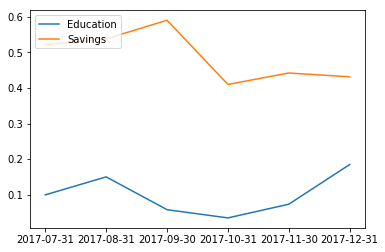

In [295]:
# Get the scores over history
# Query String parameters: customer_id, page_size, page, effective_date

resp_json = []
history = ["2017-12-31", "2017-11-30", "2017-10-31", "2017-09-30", "2017-08-31", "2017-07-31"]
for effective_date in history:
    page = 0
    while True:
        scores_url = "customers/" + str(customer_id) + "/product_scores?page_size=" + str(page_size) + "&page=" + str(page) + "&effective_date="+effective_date
        print("GET page " + str(page) + " from: " + base_url + scores_url, end="\r", flush=True)
        scoresGet = requests.get(base_url + scores_url,headers=head)
        if scoresGet.status_code != 200 or scoresGet.json() == [] : break
        page = page + 1
        resp_json = resp_json + scoresGet.json()

    if scoresGet.status_code != 200:
        print('\nAn error occured getting scores')
        print('scoresGet Status Code: ' + str(scoresGet.status_code))
        print(scoresGet.text)

dfpp = json_normalize(resp_json)
dfpp = dfpp[dfpp.effective_date != "2017-06-30"]
labels = []
for product in dfpp.product_id.unique():
    current = dfpp[dfpp.product_id == product]
    plt.plot(current.effective_date,current.score_value)
    labels.append(product)

plt.legend(labels, loc='upper left')

<a href="#top">Return to Top</a>